### 1. 가속도계, 자기장계 데이터 불러오기

In [ ]:
import pandas as pd
import math

acc_df = pd.read_csv("data/iPhone15-241121-path1/Accelerometer.csv")
mag_df = pd.read_csv("data/iPhone15-241121-path1/MagnetometerUncalibrated.csv")


In [2]:
len(acc_df), len(mag_df)

(30226, 30464)

In [3]:
# 가속도계와 자기장계의 시간이 불일치하는 데이터 건수
len(set(mag_df["seconds_elapsed"]) - set(acc_df["seconds_elapsed"]))

30460

In [4]:
# 자기장 magnitude 구하기 (norm L2)
mag_df['L2'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
mag_df

,time,seconds_elapsed,z,y,x,L2
0,1732189814533091000,0.179091,-201.199219,-363.448120,159.098160,444.845913
1,1732189814543013000,0.189013,-201.367813,-362.849304,159.442734,444.556632
2,1732189814552935200,0.198935,-201.342392,-362.456970,159.795624,444.351725
3,1732189814562857200,0.208857,-201.275040,-362.011749,160.079056,444.060190
4,1732189814572779300,0.218779,-201.210052,-361.817139,160.077972,443.871698
...,...,...,...,...,...,...
30459,1732190116692422100,302.338422,-200.905090,-364.590698,154.053375,443.871237
30460,1732190116702340400,302.348340,-200.655594,-364.319427,154.381042,443.649432
30461,1732190116712259300,302.358259,-201.263947,-364.097321,154.100632,443.645173
30462,1732190116722178300,302.368178,-200.979233,-363.797607,153.989899,443.231587


### 2. 가속도 z축 방향 데이터로 step 딛은 Time 유추하기 (find_peaks)

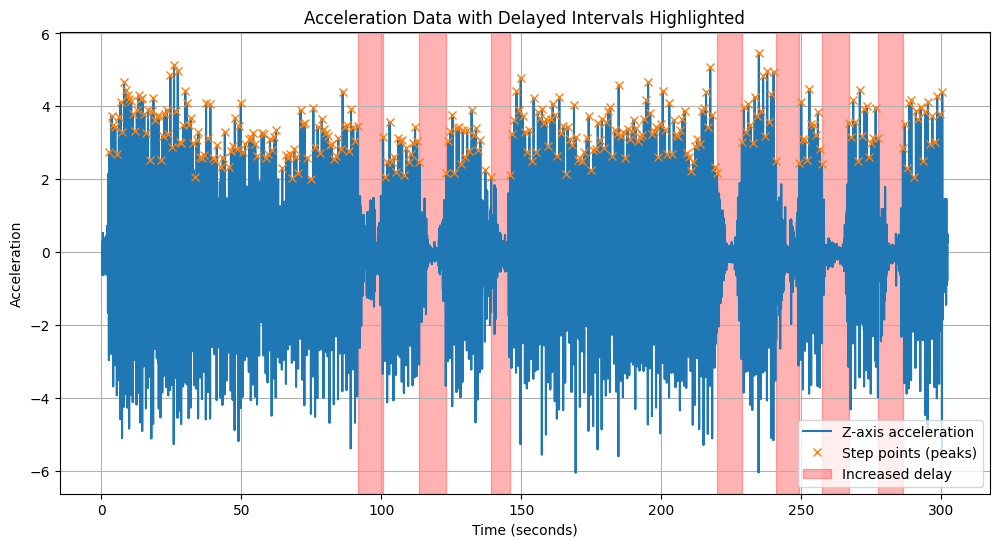

Delayed intervals 발생한 시점: [ 91.52894824 113.65244531 139.27490405 219.90115186 241.00490308
 257.48000854 277.66397729]
Delayed intervals 발생한 시점의 인덱스 번호: [117 135 154 252 269 281 295]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

time = acc_df["seconds_elapsed"].to_numpy()
z_acc = acc_df["z"].to_numpy()

# 피크 찾기 (=step을 딛은 모든 시점의 인덱스 번호)
peaks, _ = find_peaks(z_acc, height=2, distance=50)  # height는 최소 높이, distance는 최소 간격

# 각 피크(step) 간의 시간 간격 구하기
peak_times = time[peaks]  # Convert indices to time
intervals = np.diff(peak_times)  # Time differences between peaks

# Delayed intervals : 피크(step) 간의 시간 간격이 비교적 큰 경우 찾기 (그래프에서 빨간색으로 표시) <- 도착해서 잠시 쉰 지점들
threshold = 5 * np.median(intervals)
delay_indices = np.where(intervals > threshold)[0]  # Indices where delay is significant


# Visualization
plt.figure(figsize=(12, 6))
plt.plot(time, z_acc, label="Z-axis acceleration")
plt.plot(peak_times, z_acc[peaks], "x", label="Step points (peaks)")
for i in delay_indices:
    plt.axvspan(peak_times[i], peak_times[i + 1], color='red', alpha=0.3, label="Increased delay" if i == delay_indices[0] else None)

plt.title("Acceleration Data with Delayed Intervals Highlighted")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid()
plt.show()

# Output the intervals and delayed sections
print("Delayed intervals 발생한 시점:", peak_times[delay_indices])
print("Delayed intervals 발생한 시점의 인덱스 번호:", delay_indices)

### 3. M-Map 생성 (<x, y, mag>의 리스트)

In [6]:
# 각 지점의 좌표: (1번 지점), (2번 지점), ..., (8번 지점), (1번 지점)
points = [(9,47),(140,47),(144,34),(140,10),(40,10),(40,27),(30,27),(20,37),(9,47)]
# 각 경로의 인덱스 시작과 끝: (1번, 2번), (2번, 3번), ..., (7번, 8번), (8번, 1번)
indices = [(0,117),(118,135),(136,154),(155,252),(253,269),(270,281),(282,295),(296,313)]

print(f"{len(points)=}, {len(indices)=}")

len(points)=9, len(indices)=8


In [7]:
# 각 step 시점에 해당되는 자기장 데이터만 뽑아내기
mag_L2 = mag_df["L2"].to_numpy()
mag_L2_sample = mag_L2[peaks]

In [8]:
# 각 지점의 좌표, 각 경로의 인덱스 시작과 끝 기준으로 좌표별 자기장 값 채우기 (M-Map)

# (예시) "1번 지점" -> "2번 지점" 사이의 mmap 계산 하는 코드
# x = np.linspace(9, 140, 131 + 1)
# y = np.linspace(47, 47, 131 + 1)
# mag = mag_L2_sample[0:131+1]

x,y,mag = [],[],[]

i=0
for start_idx, end_idx in indices:
    x.append(np.linspace(points[i][0], points[i+1][0], end_idx-start_idx+ 1))
    y.append(np.linspace(points[i][1], points[i+1][1], end_idx-start_idx+ 1))
    mag.append(mag_L2_sample[start_idx:end_idx+1])
    i+=1

mmap_df = pd.DataFrame({"X":np.concatenate(x), 
                        "Y":np.concatenate(y),
                        "mag":np.concatenate(mag)})

mmap_df

,X,Y,mag
0,9.000000,47.000000,445.298858
1,10.119658,47.000000,447.039295
2,11.239316,47.000000,443.752713
3,12.358974,47.000000,444.060580
4,13.478632,47.000000,444.058567
...,...,...,...
309,11.588235,44.647059,462.890799
310,10.941176,45.235294,467.574702
311,10.294118,45.823529,463.423469
312,9.647059,46.411765,458.321221


### 4. M-Map 시각화

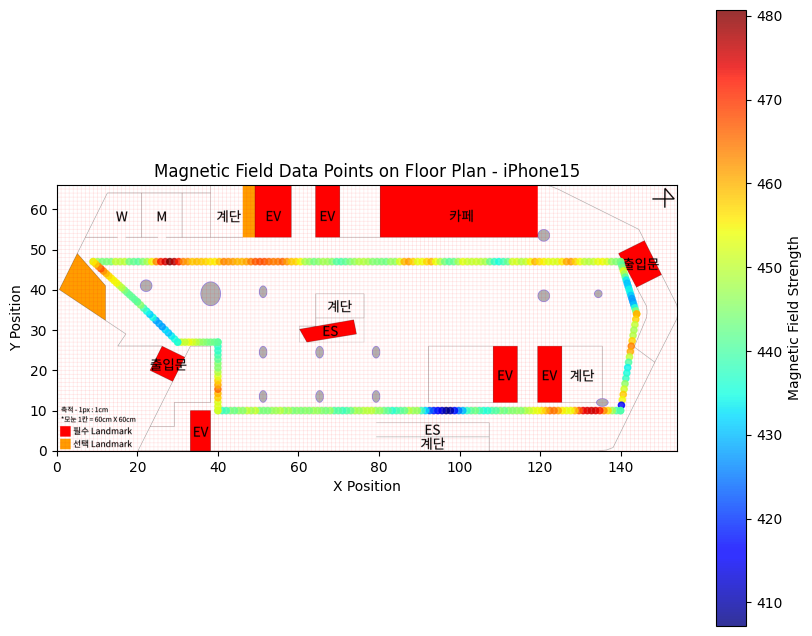

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize

# 1. 평면도 이미지 불러오기
floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
floor_plan = cv2.imread(floor_plan_path)
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환

# 2. 데이터 분리
x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# 3. 컬러 매핑 설정
norm = Normalize(vmin=np.min(mag), vmax=np.max(mag))  # 값의 범위 정규화
cmap = colormaps.get_cmap('jet')  # 컬러맵 설정
colors = cmap(norm(mag))  # 값을 컬러맵으로 변환

# 4. 평면도 위에 점만 표시
plt.figure(figsize=(10, 8))

# 평면도 이미지를 뒤집히지 않게 하기 위해 origin='upper'로 설정
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # extent=(x_min, x_max, y_min, y_max)

# 데이터 포인트에 색깔과 크기 적용
scatter = plt.scatter(x, y, c=mag, s=20, cmap=cmap, norm=norm, alpha=0.8)  # scatter의 cmap과 norm 설정

# 컬러바 추가
plt.colorbar(scatter, label='Magnetic Field Strength')  # scatter를 기반으로 컬러바 생성

plt.title('Magnetic Field Data Points on Floor Plan - iPhone15')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


### 5. 보간된 M-Map

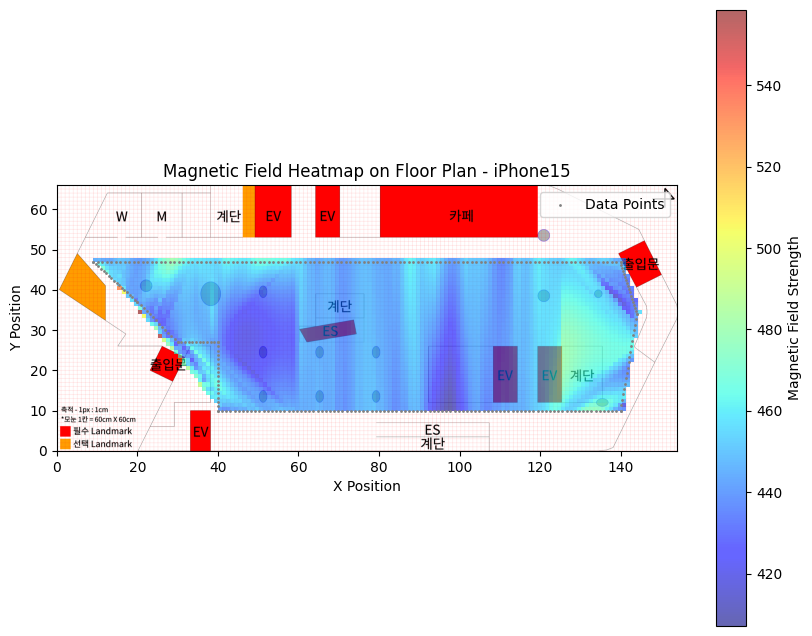

In [11]:
from scipy.interpolate import griddata

x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:154:1, 0:66:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')

mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})


# 시각화 (Heatmap 생성)
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 154, 0, 66), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan - iPhone15')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()